In [399]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [4]:
# export
import os
import torch as T
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
# export
class imagenetStats:
    def __init__(self, UseInception=True):
        self.UseInception=UseInception
        self.IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
        self.IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
        self.IMAGENET_INCEPTION_MEAN = (0.5, 0.5, 0.5)
        self.IMAGENET_INCEPTION_STD = (0.5, 0.5, 0.5)
    def getMean(self):
        if self.UseInception: return self.IMAGENET_INCEPTION_MEAN[0]
        
    def getSTD(self):
        if self.UseInception: return self.IMAGENET_INCEPTION_STD[0]
        

In [7]:
transform=imagenetStats(UseInception=True)

transform.getMean(),transform.getSTD()

(0.5, 0.5)

In [8]:
# export
def set_seed(x): 
    #random.seed(x)
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark = False
    if T.cuda.is_available(): 
        T.cuda.manual_seed_all(x)

In [9]:
set_seed(42)

In [10]:
# export 
def byte2np_RGB(response, Save=False, path='data', filename='Test'):
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8)
    # reshape array to 4 channel image array H X W X 4
    img_rgb = img1d.reshape(3, response.height, response.width)
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, img_rgb)
    return img_rgb

In [11]:
# export 
def byte2np_Depth(response, Save=False, path='data', filename='Test'):
    img1d = np.array(response.image_data_float, dtype=np.float)
    img1d = img1d * 3.5 + 30
    img1d[img1d > 255] = 255
    depth = np.reshape(img1d, (response.height, response.width))
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, depth)
    return depth

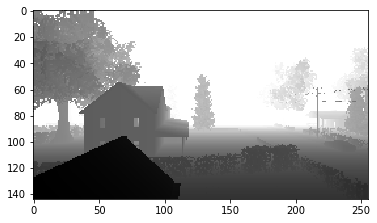

In [12]:
depth=np.load('data/Front_center_DepthPlanar.npy')
plt.imshow(depth, interpolation='nearest', cmap='gray')
plt.show()

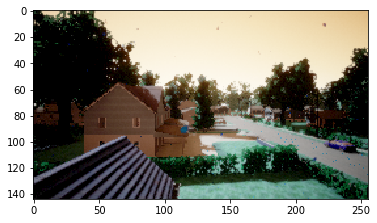

In [13]:
img=np.load('data/Front_center_RGB.npy')
img=img.reshape(img.shape[1], img.shape[2],3)

plt.imshow(img, interpolation='nearest')
plt.show()

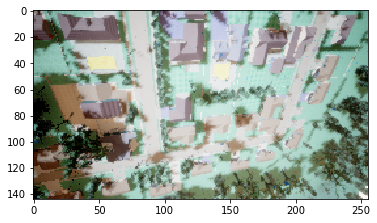

In [410]:
img=np.load('data/Bottom_center_RGB.npy')
img=img.reshape(img.shape[1], img.shape[2],3)
plt.imshow(img, interpolation='nearest')
plt.show()

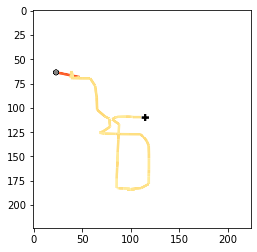

In [411]:
img=np.load('data/GPS.npy')
img=img.reshape(img.shape[1], img.shape[2],3)
plt.imshow(img, interpolation='nearest')
plt.show()

In [412]:
img.shape

(224, 224, 3)

In [413]:
def Value2Color(val, vmin=0, vmax=1, palette='YlOrRd', zerocolor='#e3e3e3'):    
    """Input value from vmin to vmax returns hex color based on value and palette"""
    import matplotlib as mpl
    import matplotlib.cm as cm
    try:
        if np.isnan(val):
            clr='#e3e3e3' # grey
        elif val==0: clr=zerocolor# green if zero
        else:
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            cmap = cm.get_cmap(palette)   
            m = cm.ScalarMappable(norm=norm, cmap=cmap)
            rgba=m.to_rgba(val)
            clr=mpl.colors.to_hex(rgba)
    except: clr='#e3e3e3' # grey
    return clr

In [414]:
# export
def plotcolorline(x, y, z, cmap='YlOrRd', norm=plt.Normalize(0.0, 1.0), 
              linewidth=3, alpha=1.0):
    #breaks lines into segments and plots segment color as z value in colormap
    import matplotlib.collections as mcoll
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)

    return lc

In [415]:
#function to convert x, y , z vector to gps coordinates needed
# c++
_='''static GeoPoint nedToGeodetic(const Vector3r& v, const HomeGeoPoint& home_geo_point)
        {
            double x_rad = v.x() / EARTH_RADIUS;
            double y_rad = v.y() / EARTH_RADIUS;
            double c = sqrt(x_rad * x_rad + y_rad * y_rad);
            double sin_c = sin(c), cos_c = cos(c);
            double lat_rad, lon_rad;
            if (!Utils::isApproximatelyZero(c)) { //avoids large changes?
                lat_rad = asin(cos_c * home_geo_point.sin_lat + (x_rad * sin_c * home_geo_point.cos_lat) / c);
                lon_rad = (home_geo_point.lon_rad +
                           atan2(y_rad * sin_c, c * home_geo_point.cos_lat * cos_c - x_rad * home_geo_point.sin_lat * sin_c));

                return GeoPoint(Utils::radiansToDegrees(lat_rad), Utils::radiansToDegrees(lon_rad), home_geo_point.home_geo_point.altitude - v.z());
            }
            else
                return GeoPoint(home_geo_point.home_geo_point.latitude, home_geo_point.home_geo_point.longitude, home_geo_point.home_geo_point.altitude - v.z());
        }'''

# this is the print statement from self.client.getGpsData():
_='''<GpsData> {   'gnss': <GnssReport> {   'eph': 0.3000044822692871,
    'epv': 0.40000447630882263,
    'fix_type': 3,
    'geo_point': <GeoPoint> {   'altitude': 132.32289123535156,
    'latitude': 47.6416150728889,
    'longitude': -122.14040436968116},
    'time_utc': 1645971445395087,
    'velocity': <Vector3r> {   'x_val': -0.24463589489459991,
    'y_val': 0.05023214593529701,
    'z_val': -0.6591682434082031}},
    'is_valid': True,
    'time_stamp': 1645971445395087360} <Vector3r> {   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355}
'''

In [416]:
# export
class GPShistory:
    def __init__(self, position, velocity, reward, time_stamp, vehicle_name, image_size, maxspeed):
        self.columns=['x_position', 'y_position', 'z_position',
                     'x_velocity', 'y_velocity', 'z_velocity', 
                     'Reward', 'time_stamp', 'vehicle_name']
        self.sz=image_size
        self.vehicle_name=vehicle_name
        self.maxspeed= maxspeed
        self.df=pd.DataFrame([[position.x_val, position.y_val, position.z_val,
                               velocity.x_val, velocity.y_val, velocity.z_val,
                              reward, time_stamp,vehicle_name]], columns=self.columns)
        
    def appendGPShistory(self, position, velocity, reward, time_stamp, vehicle_name):
        self.df.loc[len(self.df)]= [position.x_val, position.y_val, position.z_val,
                                    velocity.x_val, velocity.y_val, velocity.z_val,
                                    reward, time_stamp,vehicle_name]
        
    def saveGPS2csv(self, filename):
        self.df.to_csv(filename, index=False)
        
    def loadGPScsv(self, filename):
        self.df=pd.read_csv(filename)
        
    def GPS2image(self, Save=False, path='data', filename='Test'):
        df=self.df.copy()
        # no fly zones still need to be implimented
        df['VELOCITY']=np.sqrt(df['x_velocity']*df['x_velocity']+df['y_velocity']*df['y_velocity']+df['z_velocity']*df['z_velocity'])
        # ensures the current vehicle is plotted last
        vehicle_lst=list(df[df['vehicle_name']!=self.vehicle_name]['vehicle_name'].dropna().unique())+[self.vehicle_name]
        #################################### Plotting #########################################################
        fig, ax = plt.subplots(figsize=(5,5))
        # add reward colors
        frame=df[df['Reward']>0].copy()
        plt.plot(frame['x_position'], frame['y_position'], marker='o', color="green", ms=12,linestyle='None')
        frame=df[df['Reward']<0].copy()
        plt.plot(frame['x_position'], frame['y_position'], marker='o', color="red", ms=8,linestyle='None')

        for v_name in vehicle_lst:
            frame=df[df['vehicle_name']==v_name].copy()
            if v_name==self.vehicle_name:
                clr='YlOrRd'; rad=20
                x_cntr=frame.loc[frame.index[-1],'x_position']
                y_cntr=frame.loc[frame.index[-1],'y_position']
                # plt.plot(frame['x_position'], frame['y_position'], color='k', lw=6) # makes a black edge to line (not working in linux)
                # set the most recent position to the center of plot and shows 20 meters in all directions
                plt.xlim(x_cntr-rad,x_cntr+rad); plt.ylim(y_cntr-rad,y_cntr+rad)

            else: clr= 'Greys'
            # line plot where color is velocity
            lc = plotcolorline(frame['x_position'], frame['y_position'],frame['VELOCITY'],
                           cmap=clr, norm=plt.Normalize(-1, self.maxspeed), linewidth=4,alpha=1.0)
            #Last Location
            plt.plot(frame.loc[frame.index[-1],'x_position'], frame.loc[frame.index[-1],'y_position']
                     , marker='P', color="k", ms=12, markeredgecolor='white',linestyle='None')

            #honey I'm home
            plt.plot(frame.loc[frame.index[0],'x_position'], frame.loc[frame.index[0],'y_position']
                     , marker='o', color="gray", ms=8, markeredgecolor='black',linestyle='None')

        plt.tight_layout()
        plt.gca().set_axis_off()
        fig.canvas.draw()

        # plot to image array
        arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        arr = arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        plt.figure().clear()
        plt.close()
        plt.cla()
        plt.clf()
        # this padding only works for 224x224 images
        arr=cv2.resize(arr[11:arr.shape[0]-28,38:arr.shape[0]-10], (self.sz), interpolation=cv2.INTER_CUBIC)
        img=arr.copy()
        arr=arr.reshape((3,)+self.sz)
        if Save:
            filename = os.path.join(path, filename)
            np.save(filename, arr)
            fig = plt.figure()
            plt.imshow(img)
            fig.savefig(filename+'.png')
            plt.close(fig)

        return arr
    
    

In [417]:
# test data
import time

class mimic:
    def __init__(self, dct):
        self.x_val=dct.get('x_val')
        self.y_val=dct.get('y_val')
        self.z_val=dct.get('z_val')
        
        
position=mimic({   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355})
velocity=mimic({   'x_val': 1.724202156066895,
    'y_val': -2.542,
    'z_val': -1.55})

vehicle_name='Drone0'
maxspeed=8.33
sz=(224,224)
time_stamp=time.time_ns()
reward=0


In [418]:
df_gps=GPShistory(position, velocity, reward, time_stamp, vehicle_name, sz, maxspeed)

In [419]:
df_gps.df

,x_position,y_position,z_position,x_velocity,y_velocity,z_velocity,Reward,time_stamp,vehicle_name
0,14.724202,-2.943709,-9.155742,1.724202,-2.542,-1.55,0,1646167496016990200,Drone0


In [420]:
df_gps.loadGPScsv('data/gps_data_Drone0_episode1.csv')

In [421]:
df_gps.df.sample(7)

,x_position,y_position,z_position,x_velocity,y_velocity,z_velocity,Reward,time_stamp,vehicle_name
4,10.286687,-2.506311,-9.059245,-0.464433,0.004238,0.328095,0,1646094003518442934,Drone0
63,6.944712,2.987815,-11.789248,1.184372,-0.057760,-0.194429,0,1646094103264623848,Drone0
18,2.599276,8.113539,-11.932506,-0.872584,-0.187561,-0.103429,0,1646094027186937035,Drone0
0,15.176268,-3.046318,-7.014816,3.961711,-0.777144,1.240317,0,1646093994837329156,Drone0
28,5.180685,2.757615,-8.990885,0.883819,0.009062,0.056735,0,1646094044054722715,Drone0
72,11.122876,3.150294,-12.406549,0.001150,0.000629,-0.592001,0,1646094118439032078,Drone0
10,6.249478,1.420120,-10.603837,0.210168,0.869754,-0.097976,0,1646094013640079670,Drone0


In [422]:
arr=df_gps.GPS2image()

<Figure size 432x288 with 0 Axes>

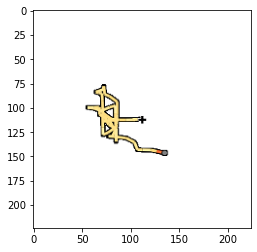

In [423]:
img=arr.reshape(sz+(3,))
plt.imshow(img)
plt.show()

In [424]:
# images come in [red_t0, green_t0, blue_t0, depth_t0, segemention_t0, 
#               grey_t-1, grey_t-2, grey_t-3, red_map, green_map, blue_map ]

In [425]:
sz=(224,224)
previous_tensor = np.random.random_sample((11,h,w))
img_rgb = np.random.random_sample((3,h,w))
img_map = np.random.random_sample((3,h,w))
seg = np.random.random_sample((1,h,w))

In [434]:
x,y,z

(3.724202156066895, -2.542, -1.55)

In [3]:
!python notebook2script.py Utilities.ipynb

Converted Utilities.ipynb to nb_files/nb_Utilities.py


In [14]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Tuesday March 01, 2022 at 19:09
